# Adtracking Fraud Detection

by Kyle O'Brien, Catherine Lee, Amit Saxena 

Data is in "data/" and includes the training and testing csv files.
Evaluation metrics will include looking at R^2 and a confusion matrix.

In [512]:
import numpy as np         # linear algebra
import sklearn as sk       # machine learning
import pandas as pd        # reading in data files, data cleaning
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns      # visualization tool
import tensorflow as tf    # low level machine learning tool
import keras               # high level machine learning API
import pickle              # serializing and deserializing objects


In [513]:
sns.set(style="darkgrid")

### Our Training Sets

`train.csv`: 184,903,890 rows of training data.  This is the complete set of training data given by kaggle. 

`train_sample.csv`: 100,000 randomly-selected rows of training data (because the full training data is too large to load and train on our feable machines)

`equalized_train.csv`: 91,473 randomly-selected rows of training data that we manually compiled to have roughly the same amount of fraudelent and non-fraudalent clicks   

In [514]:
#load and train on equalized data set

data = pd.read_csv("data/equalized_train.csv")

data.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0


In [515]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 8 columns):
ip                 91473 non-null int64
app                91473 non-null int64
device             91473 non-null int64
os                 91473 non-null int64
channel            91473 non-null int64
click_time         91473 non-null object
attributed_time    41473 non-null object
is_attributed      91473 non-null int64
dtypes: int64(6), object(2)
memory usage: 5.6+ MB


## Feature Engineering for Click Time

Lets create new columns from `click_time` that models can use for predictions

`click_time_epoch`: Number of seconds from the UNIX epoch of the click time

`click_time_secs` : Number of seconds since the start of the day for the click time

`click_time_mins` : Number of minutes since the start of the day for the click time


In [516]:
                
def feature_engineer_click_time(data):
    data['click_time'] = pd.to_datetime(data['click_time'])
    s_sec = data['click_time'].dt.second
    m_sec = data['click_time'].dt.minute*60
    hr_sec = data['click_time'].dt.hour*3600

    data['click_time_secs'] = s_sec + m_sec + hr_sec
    data['click_time_mins'] = data['click_time_secs'] // 60
    data['click_time_epoch'] = (data['click_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') 

def feature_engineer_attributed_time(data):
    data['attributed_time'] = pd.to_datetime(data['attributed_time'])



In [517]:
feature_engineer_click_time(data)
feature_engineer_attributed_time(data)

In [518]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 11 columns):
ip                  91473 non-null int64
app                 91473 non-null int64
device              91473 non-null int64
os                  91473 non-null int64
channel             91473 non-null int64
click_time          91473 non-null datetime64[ns]
attributed_time     41473 non-null datetime64[ns]
is_attributed       91473 non-null int64
click_time_secs     91473 non-null int64
click_time_mins     91473 non-null int64
click_time_epoch    91473 non-null int64
dtypes: datetime64[ns](2), int64(9)
memory usage: 7.7 MB


### Other feature engineering

In [519]:
# turning features into the categorical data type for pandas to run statistics like count, top, frequency, and uniqueness 
def feature_engineering_to_categorical(data,features=None):
    for feature in features:
        data[feature] = data[feature].astype("category")
        
def feature_engineering_to_int(data,features=None):
    for feature in features:
        data[feature] = data[feature].astype("int")

# Understanding our Dataset

In [520]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_time_secs,click_time_mins,click_time_epoch
0,83252,3,1,16,379,2017-11-06 15:42:19,NaT,0,56539,942,1509982939
1,106590,3,1,25,379,2017-11-06 15:43:23,NaT,0,56603,943,1509983003
2,147164,14,1,28,134,2017-11-06 16:00:00,NaT,0,57600,960,1509984000
3,39782,2,1,10,205,2017-11-06 16:00:00,NaT,0,57600,960,1509984000
4,121646,23,1,13,153,2017-11-06 16:00:00,NaT,0,57600,960,1509984000


### Correlations in our features 

All features with correlation to fraud:
['ip', 'app', 'device', 'os', 'channel', 'is_attributed']


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

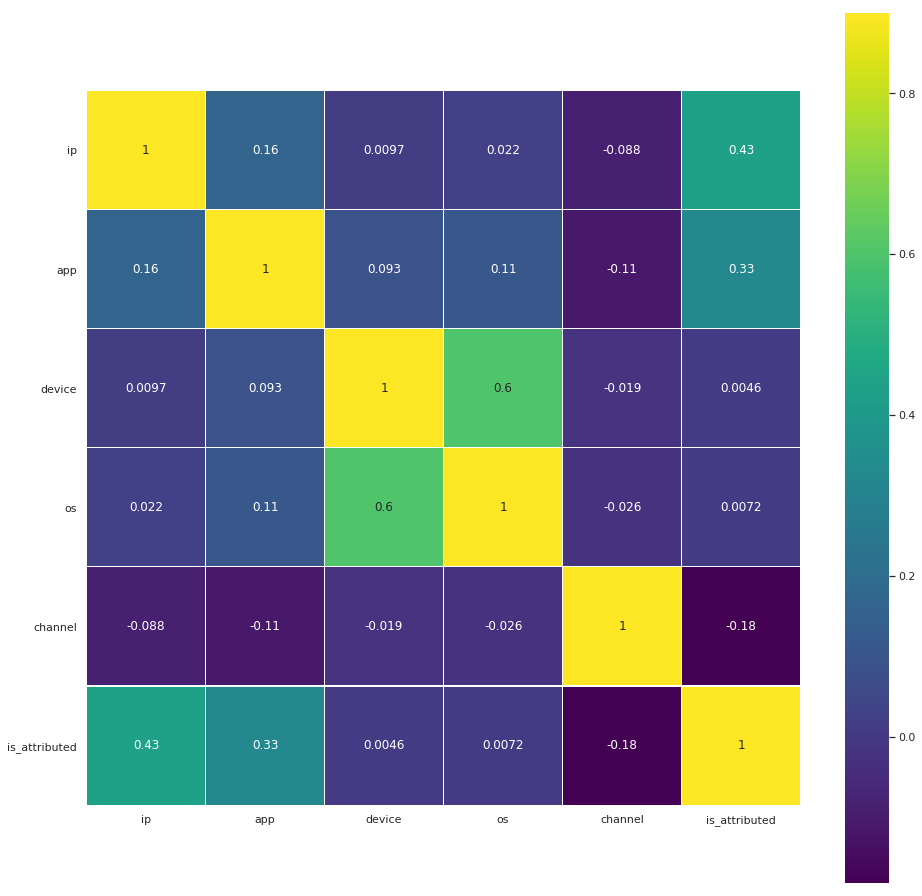

In [521]:

selectors = ['ip','app','device','os','channel','click_time','is_attributed']

correlation = data[selectors].corr()
cols = correlation['is_attributed'].index


print('All features with correlation to fraud:')
print(list(cols))   # the k variables that correlate most highly with is_attributed

cm = np.corrcoef(data[cols].values.T)
f , ax = plt.subplots(figsize = (16, 16))
sns.heatmap(cm, 
            vmax = .9, 
            linewidths = 0.01, 
            square = True, 
            annot = True, 
            cmap = 'viridis',
            linecolor = "white", 
            xticklabels = cols.values, 
            annot_kws = {'size': 12}, 
            yticklabels = cols.values)

plt.xticks(rotation=0)
plt.yticks(rotation=0)



It seems that there are not much corrolations between the `is_attribute` column and other features.  This makes sense since the other features are all identifers (categorical values)

### Treating features as categorical data

So let's turn the other features into categorical data types so Pandas can compute cool stastics like count, top, frequency, and uniqueness 

In [522]:
feature_engineering_to_categorical(data,features=["ip","app","device","os","channel","is_attributed"])

data.dtypes

ip                        category
app                       category
device                    category
os                        category
channel                   category
click_time          datetime64[ns]
attributed_time     datetime64[ns]
is_attributed             category
click_time_secs              int64
click_time_mins              int64
click_time_epoch             int64
dtype: object

In [523]:
data.describe(exclude=np.number)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,91473.0,91473.0,91473.0,91473.0,91473.0,91473,41473,91473.0
unique,46200.0,194.0,652.0,118.0,164.0,51209,37194,2.0
top,73487.0,19.0,1.0,19.0,213.0,2017-11-06 16:03:16,2017-11-09 12:46:55,0.0
freq,402.0,12185.0,74678.0,18763.0,12192.0,17,5,50000.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 15:42:19,2017-11-06 16:01:05,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 15:59:07,2017-11-09 15:59:57,NaN


### Distribution of fraudalent vs non-fraudalent clicks

Let's plot the distribution of fraudalent vs non-fraudalent clicks in our equalized set

In [524]:
class_counts = data.groupby('is_attributed').size()
class_counts.index = ['(0)fraudalent','(1)not fraudalent']
print("'is_attribute' distribution\n")
print(class_counts)

'is_attribute' distribution

(0)fraudalent        50000
(1)not fraudalent    41473
dtype: int64


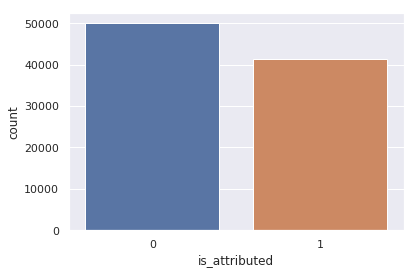

In [525]:
# Count of Fraudulent vs Non-Fraudulent
ax = sns.countplot(x="is_attributed", data=data)

The equalized training set has roughly equal distrubition of fraudalent and non-fraudalent clicks, that's good because the default training sets had 99% of clicks fraudalent.  That was causing our models to guess fraudalent on all test data

## Plotting fraudalent and non fraudalent counts against time

Now let's see the distribution of fraudalent and non-fraudalent clicks against click-time.

(CLICK IN THE BELOW CELL VISUALIZATION TO ZOOM IN)

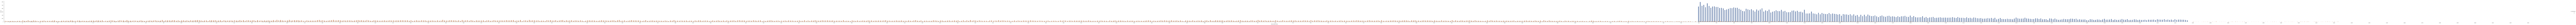

In [526]:
# CLICK to zoom in 
# a visualization of where in time the clicks happen
with sns.axes_style('white'):
    g = sns.catplot("click_time_mins", data=data, aspect = 100, kind = 'count',
                    hue = 'is_attributed')
    g.set_xticklabels(step = 10)

# Models

In [527]:
# change features back to integer data types because that's what models use
feature_engineering_to_int(data,features=["ip","app","device","os","channel","is_attributed"])


# Logistic Regression

In [528]:
X = data[['app', 'device', 'os', 'channel']]
y = data['is_attributed']

In [529]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [530]:
X_train.head()

,app,device,os,channel
22243,2,1,20,477
58933,105,1,17,451
50574,18,3032,607,107
63812,11,1,13,325
52847,116,1,41,101


In [531]:
y_train.head()

22243    0
58933    1
50574    0
63812    1
52847    1
Name: is_attributed, dtype: int64

In [532]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [533]:
logreg.fit(X_train, y_train)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [534]:
predictions = logreg.predict(X_test)

In [535]:
logreg_score = logreg.score(X_test, y_test)
print("Logistic Regression Accuracy", logreg_score)

Logistic Regression Accuracy 0.6349822355834928


The accuracy on the validation data is only 63%.  Let's try other models to see if we can get better accuracy

# Random forest

In [536]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train,y_train)
rf_score = RandomForest.score(X_test,y_test)
print("Random Forest accuracy:", rf_score)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.9345176277671495


In [537]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = RandomForest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9971
           1       0.96      0.89      0.93      8324

   micro avg       0.93      0.93      0.93     18295
   macro avg       0.94      0.93      0.93     18295
weighted avg       0.94      0.93      0.93     18295



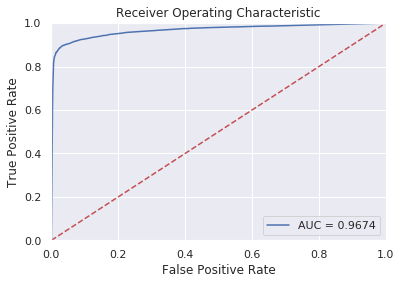

In [538]:
from sklearn.metrics import roc_curve, auc


# Visualizing through AOC - ROC chart (Area Under Curve - Receiver Operating Characteristics)

# An AOC of 1 means our model performs perfectly and an AOC of .45 means we have no discriminate classification and an AOC
# of 0 means we are predicting the exact opposite of correct values


proba = RandomForest.predict_proba(X_test)
proba = np.delete(proba, 0, 1)

fpr, tpr, thresh = roc_curve(y_test,proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
sns.set()




As demonstrated from the ROC graph, RandomForests achieve an AUC of almost close to 1 which means that we're predicting labels correctly 96% of the time.  This is very good.  

# Support Vector Machine

In [539]:
from sklearn.svm import LinearSVC 

In [540]:
lSVC = LinearSVC()

In [541]:
lSVC.fit(X_train,y_train)
svm_score = lSVC.score(X_test,y_test)
print("SVM accuracy:", svm_score)

SVM accuracy: 0.5687892866903526


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Decision Tree

In [542]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

dtc = dtc.fit(X_train,y_train)
dtc_score =  dtc.score(X_test,y_test)
print("Decision Tree Accuracy:", dtc_score)

Decision Tree Accuracy: 0.9350095654550423


In [543]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9971
           1       0.96      0.89      0.93      8324

   micro avg       0.94      0.94      0.94     18295
   macro avg       0.94      0.93      0.93     18295
weighted avg       0.94      0.94      0.93     18295



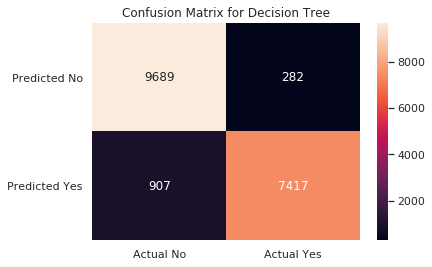

In [544]:
# Confusion Matrix for Decision Trees

from sklearn.metrics import confusion_matrix


cmat = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix for Decision Tree")

annot = pd.DataFrame(cmat)

ax = sns.heatmap(cmat, annot=annot, fmt="d", xticklabels=['Actual No', 'Actual Yes'], yticklabels=['Predicted No', 'Predicted Yes'])
ax.tick_params(axis='y', rotation=0)


Confusion Matrix shows that among the mis-labaled clicks, a significant percentage are False Positives.  This means that if we were to improve this model, we want to optimize non-fraudalent predictions to be more selective

# KNN

In [545]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
knn_score = knn.score(X_test, y_test)


# Gaussian Naive Bayes

In [546]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
gaussian_score = gaussian.score(X_test, y_test) 

# SGD

In [547]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
sgd_score = sgd.score(X_test, y_test)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# Perceptron

In [548]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
perc_score = perceptron.score(X_test, y_test)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# XGBoost

In [549]:
import xgboost as xgb



XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
XGB_score = XGB.score(X_test,y_test)

### Visualizing XGBoost Trees

Here we've shown the tree at the first iteration and last iteration of the model

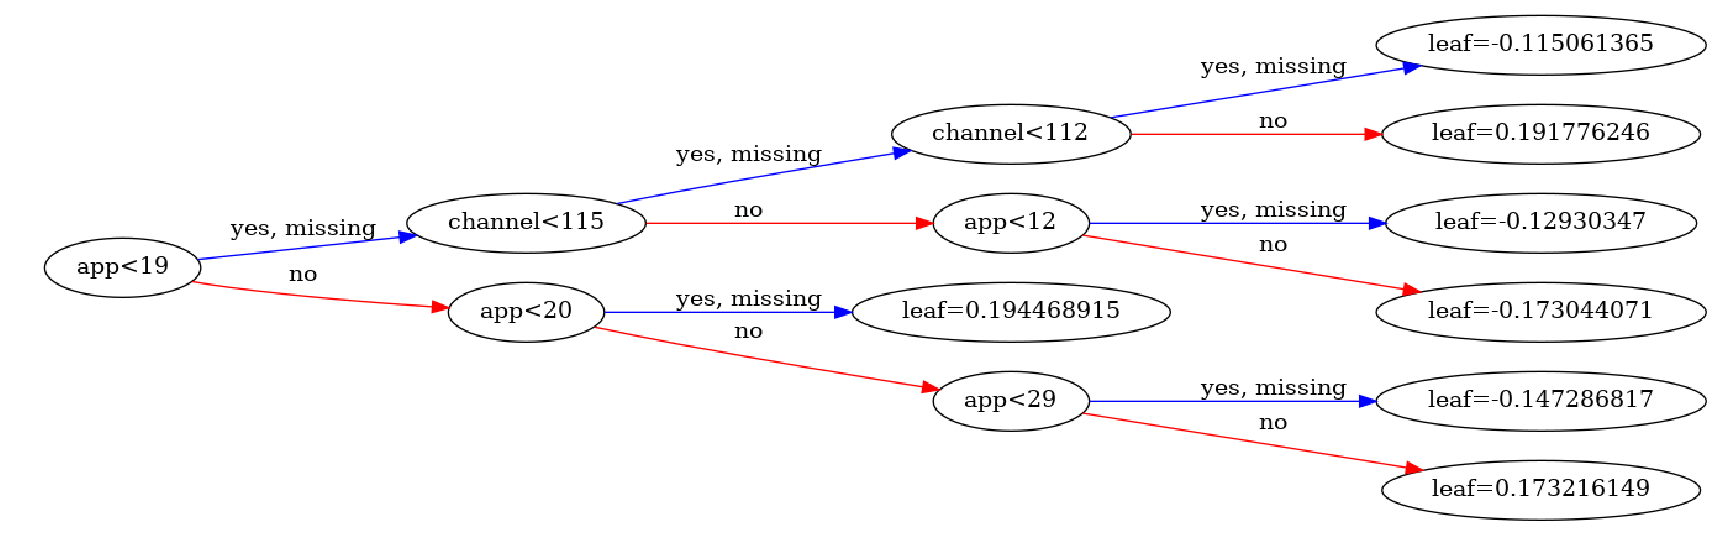

In [550]:
from xgboost import plot_tree



import graphviz
# Visualizing xgboost decisision trees using graphiviz library

# Visualizing the first boosted tree (least sophisticated)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax, num_trees=0 , rankdir='LR')
plt.show()

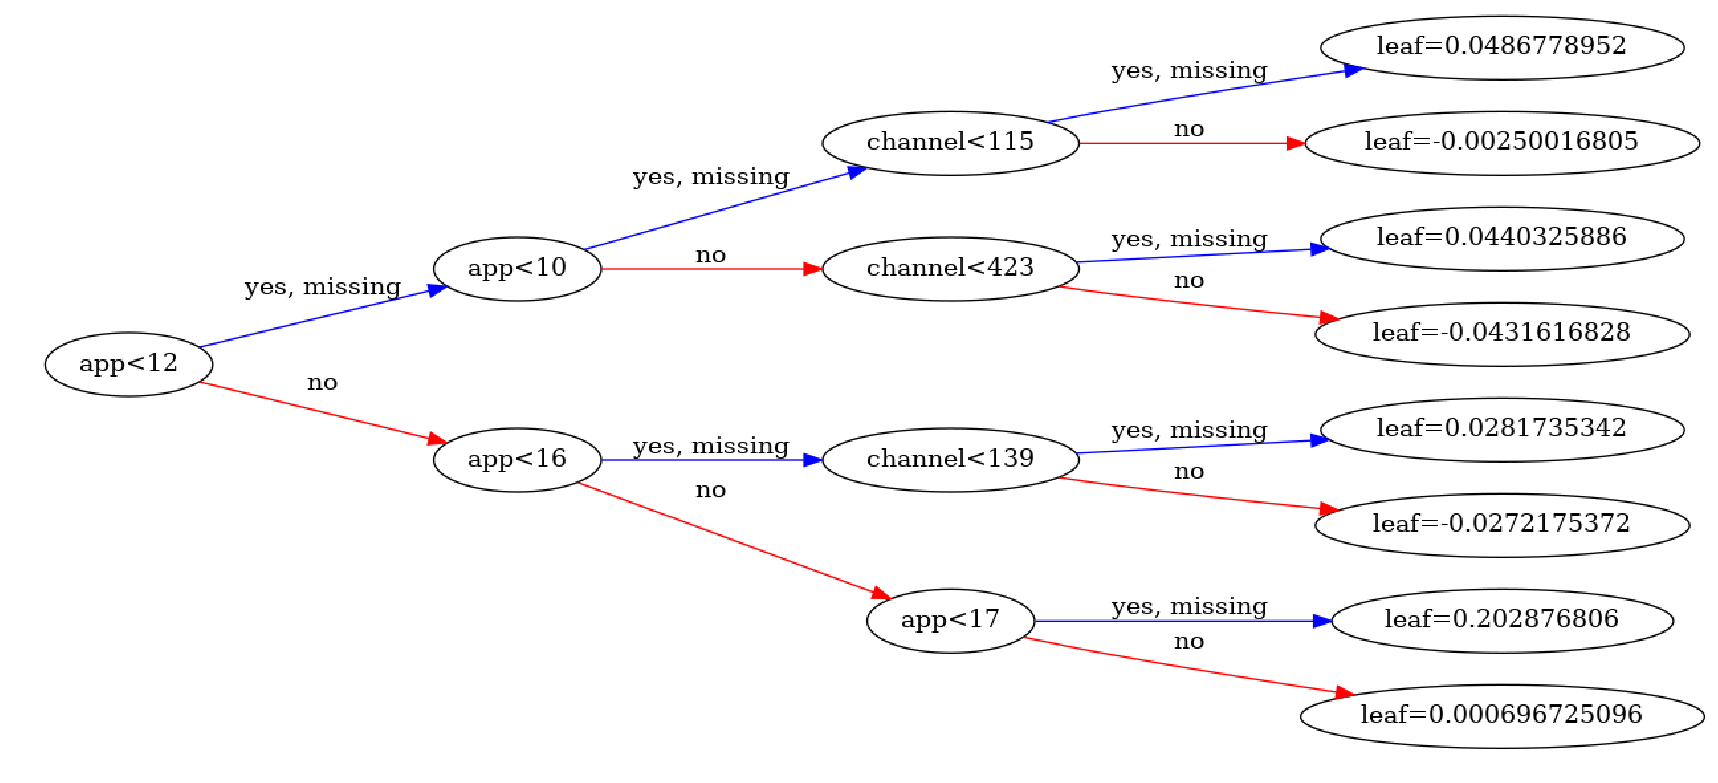

In [551]:
# visualizing the last boosted tree (most sophisticated)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax, num_trees=99 , rankdir='LR')
plt.show()

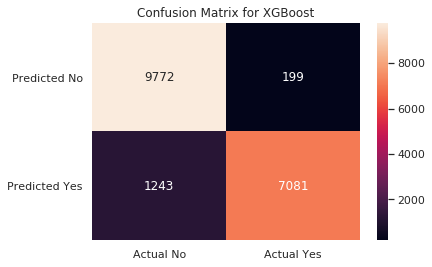

In [552]:
# XGBoost Confusion Matrix

from sklearn.metrics import confusion_matrix

y_pred = XGB.predict(X_test)

cmat = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix for XGBoost")

annot = pd.DataFrame(cmat)

ax = sns.heatmap(cmat, annot=annot, fmt="d", xticklabels=['Actual No', 'Actual Yes'], yticklabels=['Predicted No', 'Predicted Yes'])
ax.tick_params(axis='y', rotation=0)

The Confusion Matrix for XGB Boost is very similiar to Decision Trees but with a few more False Positives.  

# Gradient Boosted Trees

In [553]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train, y_train)
gbt_acc = gbt.score(X_test, y_test)

# Voting Classifier/ Ensemble Learning

In [554]:
from sklearn.ensemble import VotingClassifier

#dictionary of our models
model1 = xgb.XGBClassifier()
model2 = tree.DecisionTreeClassifier()
model3 = RandomForestClassifier() 
estimators=[('xgboost', model1), ('decisiontree', model2), ('randomforest', model3)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')


# Adaboost

In [555]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
adaboost_acc = adaboost.score(X_test,y_test)


# Bagging Classifer

In [556]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
bag = bag.fit(X_train,y_train)
bag_acc = bag.score(X_test,y_test)

# Extra Trees Classifier

In [557]:
from sklearn.ensemble import ExtraTreesClassifier
xtrees = ExtraTreesClassifier()
xtrees = xtrees.fit(X_train,y_train)
xtrees_acc = xtrees.score(X_test,y_test)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Which model do we use?

In [558]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 
              'Decision Tree', 'K Nearest Neighbors', 
              'Gaussian Naive Bayes', 'Stochastic Gradient Descent', 
              'Perceptron', 'XGBoost', 'Gradient Boosted Trees', 'Adaboost', 'Bagging Classifier'],
    'Score': [svm_score, logreg_score, rf_score, dtc_score, 
              knn_score, gaussian_score, sgd_score, perc_score, 
              XGB_score, gbt_acc, adaboost_acc, bag_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Decision Tree,0.935010
2,Random Forest,0.934518
11,Bagging Classifier,0.934463
9,Gradient Boosted Trees,0.924460
4,K Nearest Neighbors,0.921235
8,XGBoost,0.921181
10,Adaboost,0.914949
6,Stochastic Gradient Descent,0.709483
5,Gaussian Naive Bayes,0.688385
1,Logistic Regression,0.634982


# Classification Report of Every Model

In [559]:
models = {"Logistic Regression":logreg,
          "Random Forest":RandomForest, 
          "SVM":lSVC,
          "Decision Tree":dtc, 
          "KNN":knn, 
          "Gauss":gaussian, 
          "Stochastic Gradient Descent":sgd, 
          "Perceptron":perceptron, 
          "XGBoost":XGB, 
          "Gradient Boosted Trees":gbt,
          "Adaboost":adaboost, 
          "Bagging Classifier":bag}
for elem in models:
    print(elem)
    y_pred = models[elem].predict(X_test)
    print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      9971
           1       0.65      0.43      0.52      8324

   micro avg       0.63      0.63      0.63     18295
   macro avg       0.64      0.62      0.61     18295
weighted avg       0.64      0.63      0.62     18295

Random Forest
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9971
           1       0.96      0.89      0.93      8324

   micro avg       0.93      0.93      0.93     18295
   macro avg       0.94      0.93      0.93     18295
weighted avg       0.94      0.93      0.93     18295

SVM
              precision    recall  f1-score   support

           0       0.56      0.99      0.72      9971
           1       0.89      0.06      0.11      8324

   micro avg       0.57      0.57      0.57     18295
   macro avg       0.73      0.53      0.41     18295
weighted avg       0.71      0.57   

# Neural Network

In [560]:
from keras.models import Sequential
from keras.layers import Dense

#60,30,1 --> .9156 acc with .234 loss
#20,10,1 --> .9122 acc, .2576 loss
#10,5,1 --> val: .9064 acc, .279 loss
#30,10,1 --> .9117 acc, .239 loss
#60,10,1 --> .918 acc , .230 loss
#70,10,1 --> .913, .238
#50,10,1 --> .917 , .229
#40,10,1 --> .918, .228
model = Sequential()
model.add(Dense(40, activation='sigmoid', input_dim = 4))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))


# can try rmsprop
model.compile(optimizer = 'adam',     
              loss = 'binary_crossentropy',
              metrics = ['accuracy']) 

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 300, 
                    batch_size = 32)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)


print('Training set accuracy:', train_acc)
print('Training set loss:', train_loss)

print('Test set accuracy:', test_acc)
print('Test set loss:', test_loss)



Train on 49029 samples, validate on 24149 samples
Epoch 1/300
49029/49029 [==============================] - 7s 146us/step - loss: 0.5478 - acc: 0.7124 - val_loss: 0.5056 - val_acc: 0.7591
Epoch 2/300
49029/49029 [==============================] - 6s 127us/step - loss: 0.4824 - acc: 0.7959 - val_loss: 0.4528 - val_acc: 0.8172
Epoch 3/300
49029/49029 [==============================] - 6s 124us/step - loss: 0.4454 - acc: 0.8181 - val_loss: 0.4304 - val_acc: 0.8297
Epoch 4/300
49029/49029 [==============================] - 6s 124us/step - loss: 0.4288 - acc: 0.8263 - val_loss: 0.4173 - val_acc: 0.8306
Epoch 5/300
49029/49029 [==============================] - 6s 124us/step - loss: 0.4138 - acc: 0.8315 - val_loss: 0.3954 - val_acc: 0.8371
Epoch 6/300
49029/49029 [==============================] - 6s 125us/step - loss: 0.3924 - acc: 0.8407 - val_loss: 0.3813 - val_acc: 0.8636
Epoch 7/300
49029/49029 [==============================] - 6s 125us/step - loss: 0.3715 - acc: 0.8638 - val_loss: 0.

49029/49029 [==============================] - 6s 120us/step - loss: 0.2532 - acc: 0.9101 - val_loss: 0.2483 - val_acc: 0.9080
Epoch 118/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2525 - acc: 0.9102 - val_loss: 0.2468 - val_acc: 0.9108
Epoch 119/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2527 - acc: 0.9101 - val_loss: 0.2922 - val_acc: 0.9053
Epoch 120/300
49029/49029 [==============================] - 6s 121us/step - loss: 0.2526 - acc: 0.9105 - val_loss: 0.2729 - val_acc: 0.9007
Epoch 121/300
49029/49029 [==============================] - 6s 121us/step - loss: 0.2531 - acc: 0.9106 - val_loss: 0.2496 - val_acc: 0.9099
Epoch 122/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2519 - acc: 0.9107 - val_loss: 0.2517 - val_acc: 0.9108
Epoch 123/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2531 - acc: 0.9100 - val_loss: 0.2601 - val_acc: 0.9072
Epoch 124/300
49029/49029 [

49029/49029 [==============================] - 6s 121us/step - loss: 0.2432 - acc: 0.9125 - val_loss: 0.2423 - val_acc: 0.9113
Epoch 234/300
49029/49029 [==============================] - 6s 119us/step - loss: 0.2443 - acc: 0.9116 - val_loss: 0.2403 - val_acc: 0.9123
Epoch 235/300
49029/49029 [==============================] - 6s 119us/step - loss: 0.2434 - acc: 0.9117 - val_loss: 0.2392 - val_acc: 0.9149
Epoch 236/300
49029/49029 [==============================] - 6s 119us/step - loss: 0.2430 - acc: 0.9122 - val_loss: 0.2401 - val_acc: 0.9126
Epoch 237/300
49029/49029 [==============================] - 6s 119us/step - loss: 0.2433 - acc: 0.9122 - val_loss: 0.2430 - val_acc: 0.9137
Epoch 238/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2443 - acc: 0.9117 - val_loss: 0.2447 - val_acc: 0.9137
Epoch 239/300
49029/49029 [==============================] - 6s 120us/step - loss: 0.2429 - acc: 0.9118 - val_loss: 0.2394 - val_acc: 0.9114
Epoch 240/300
49029/49029 [

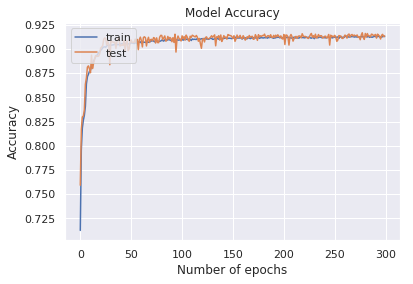

In [561]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

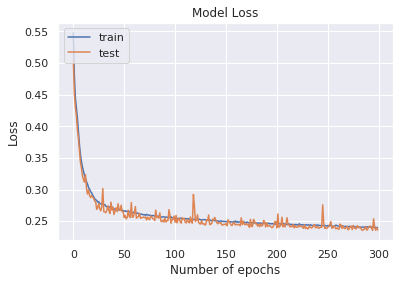

In [562]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Submitting to Kaggle with best model

### Option Parameters

In [565]:
test_file_path = "data/test.csv"# test file path 
feature_engineer = True        # do feature engineering as test file 

save_test_file = False          # save test file to disk, useful to save feature engineering work
save_path = "data/test_ct.csv"  # path for saved test file

load_model_from_file = False    # True to load the model from the specified file
model = None                    # placeholder for the model
model_file = "RF.sav"           # pickled model to load from

prediction_file = "output/prediction2.csv"

In [566]:
true_test = pd.read_csv(test_file_path)

### Feature Engineering add ons

In [567]:
if feature_engineer is True:    
    # Adding click_time_secs
    feature_engineer_click_time(true_test)

In [568]:
# Saving feature engineered test data if option is set
if save_test_file is True:
    true_test.to_csv(save_path, index=False)

In [569]:
true_test.head()

,click_id,ip,app,device,os,channel,click_time,click_time_secs,click_time_mins,click_time_epoch
0,0,5744,9,1,3,107,2017-11-10 04:00:00,14400,240,1510286400
1,1,119901,9,1,3,466,2017-11-10 04:00:00,14400,240,1510286400
2,2,72287,21,1,19,128,2017-11-10 04:00:00,14400,240,1510286400
3,3,78477,15,1,13,111,2017-11-10 04:00:00,14400,240,1510286400
4,4,123080,12,1,13,328,2017-11-10 04:00:00,14400,240,1510286400


In [570]:
# Obtain desired columns from test data  
true_test_X = true_test[['app', 'device', 'os', 'channel']]

### Loading Model

In [571]:
model = XGB  # default model since it performed as one of the best
if load_model_from_file is True:
    with open(model_file, 'rb') as inp:
        model = pickle.load(inp)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Predict on Test Data using models

In [572]:
# testing on xdg boost 
true_test_predictions = model.predict(true_test_X)

In [573]:
true_test_predictions

array([1, 0, 0, ..., 0, 0, 0])

In [574]:
import csv
# saving submission to `prediction_file`
submission = pd.DataFrame({
        "is_attributed": true_test_predictions
    })
submission.to_csv(prediction_file,index=True,index_label='click_id')


### End of Notebook!